In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('user-wallet-transactions.csv')
df.head()

,_id,userWallet,network,protocol,txHash,logId,timestamp,blockNumber,action,type,amount,assetSymbol,assetPriceUSD,poolId,userId,createdAt,updatedAt
0,681d38fed63812d4655f571a,0x00000000001accfa9cef68cf5371a23025b6d4b6,polygon,aave_v2,0x695c69acf608fbf5d38e48ca5535e118cc213a89e3d6...,0x695c69acf608fbf5d38e48ca5535e118cc213a89e3d6...,1629178166,1629178166,deposit,Deposit,2000000000,USDC,0.993832,0x2791bca1f2de4661ed88a30c99a7a9449aa84174,0x00000000001accfa9cef68cf5371a23025b6d4b6,2025-05-08T23:06:39.465Z,2025-05-08T23:06:39.465Z
1,681aa70dd6df53021cc6f3c0,0x000000000051d07a4fb3bd10121a343d85818da6,polygon,aave_v2,0xe6fc162c86b2928b0ba9b82bda672763665152b9de9d...,0xe6fc162c86b2928b0ba9b82bda672763665152b9de9d...,1621525013,1621525013,deposit,Deposit,145000000000000000000,WMATIC,1.970307,0x0d500b1d8e8ef31e21c99d1db9a6444d3adf1270,0x000000000051d07a4fb3bd10121a343d85818da6,2025-05-07T00:19:26.159Z,2025-05-07T00:19:26.159Z
2,681d04c2d63812d4654c733e,0x000000000096026fb41fc39f9875d164bd82e2dc,polygon,aave_v2,0xe2d7eb815c89331a734ed6f204a06c385a1b39040baa...,0xe2d7eb815c89331a734ed6f204a06c385a1b39040baa...,1627118913,1627118913,deposit,Deposit,1000000000000000,WMATIC,0.922377,0x0d500b1d8e8ef31e21c99d1db9a6444d3adf1270,0x000000000096026fb41fc39f9875d164bd82e2dc,2025-05-08T19:23:47.877Z,2025-05-08T19:23:47.877Z
3,681d133bd63812d46551b6ef,0x000000000096026fb41fc39f9875d164bd82e2dc,polygon,aave_v2,0x0d63a2eacd82b82f868db825ea7385e6bd8d046ee729...,0x0d63a2eacd82b82f868db825ea7385e6bd8d046ee729...,1627773318,1627773318,deposit,Deposit,4000000000000000,WMATIC,1.057483,0x0d500b1d8e8ef31e21c99d1db9a6444d3adf1270,0x000000000096026fb41fc39f9875d164bd82e2dc,2025-05-08T20:25:33.141Z,2025-05-08T20:25:33.141Z
4,681899e4ba49fc91cf2f4454,0x0000000000e189dd664b9ab08a33c4839953852c,polygon,aave_v2,0x590eabb812c5006a6f4766f44e6e9d3ad0b5b563de69...,0x590eabb812c5006a6f4766f44e6e9d3ad0b5b563de69...,1618845907,1618845907,redeemunderlying,RedeemUnderlying,501548,USDC,1.002130,0x2791bca1f2de4661ed88a30c99a7a9449aa84174,0x7f90122bf0700f9e7e1f688fe926940e8839f353,2025-05-05T10:58:45.934Z,2025-05-05T10:58:45.934Z


In [24]:
df['assetSymbol'].unique().tolist()

9

In [19]:
df['action'].unique().tolist()

['deposit', 'redeemunderlying', 'borrow', 'repay', 'liquidationcall']

In [25]:
TOKENS = {
    'USDC': 6,
    'USDT': 6,
    'DAI': 18,
    'WETH': 18,
    'WBTC': 8,
    'WMATIC': 18,
    'AAVE': 18
}

df['amount'] = pd.to_numeric(df['amount'], errors = 'coerce')

In [26]:
def format_amount(row):
    symbol = row['assetSymbol']
    if pd.isna(symbol):
        return None
    token_value = TOKENS.get(symbol,18)
    return row['amount']/(10**token_value)

In [27]:
df['amount'] = df.apply(format_amount,axis=1)

#### Feature Engineering

1. Transaction frequency

In [29]:
from datetime import datetime

df['timestamp'] = pd.to_datetime(df['timestamp'],unit='s')

wallet_groups = df.groupby('userWallet')

tr_freq = wallet_groups.size().rename('num_transactions') # transaction frequency

# recent frequencies..
latest_timestamp = df['timestamp'].max() 
last_tr_time = wallet_groups['timestamp'].max()
recently = (latest_timestamp-last_tr_time).dt.days.rename('last_transaction_days_ago')

# active duration
first_tr_time = wallet_groups['timestamp'].min()
active_days = (last_tr_time-first_tr_time).dt.days.rename('active_days')

# combine them
frequ_df = pd.concat([tr_freq,active_days,recently],axis = 1)

2. Behaviour of wallets

In [31]:
action_counts = df.pivot_table(index='userWallet',columns='action',aggfunc='size',fill_value=0)
action_props = action_counts.div(action_counts.sum(axis=1),axis=0).add_prefix('action_prop_')

In [73]:
action_props

action,action_prop_borrow,action_prop_deposit,action_prop_liquidationcall,action_prop_redeemunderlying,action_prop_repay
userWallet,,,,,
0x00000000001accfa9cef68cf5371a23025b6d4b6,0.000000,1.000000,0.0,0.000000,0.000000
0x000000000051d07a4fb3bd10121a343d85818da6,0.000000,1.000000,0.0,0.000000,0.000000
0x000000000096026fb41fc39f9875d164bd82e2dc,0.000000,1.000000,0.0,0.000000,0.000000
0x0000000000e189dd664b9ab08a33c4839953852c,0.000000,0.000000,0.0,1.000000,0.000000
0x0000000002032370b971dabd36d72f3e5a7bf1ee,0.037594,0.626566,0.0,0.325815,0.010025
...,...,...,...,...,...
0x06185db89f5c8ef5e5a0abc95c5cb69b54c33f30,0.000000,1.000000,0.0,0.000000,0.000000
0x06189341e523a52ae10c4bd4a7774371fac1b249,0.142857,0.571429,0.0,0.285714,0.000000
0x0618c450370822c5cb25ec143a3008230d8e2c12,0.000000,0.200000,0.0,0.800000,0.000000


3. Financial health

In [34]:
df['usd_value'] = df['amount'] * df['assetPriceUSD']

agg = df.pivot_table(index='userWallet',columns='action',values='usd_value',aggfunc='sum',fill_value=0)
agg.columns = [f"total_usd_{c}" for c in agg.columns]

total_usd_transaction = df.groupby('userWallet')['usd_value'].sum().rename('total_usd_transacted')

# getting the average and standard deviation per transaction.
avg_usd = wallet_groups['usd_value'].mean().rename('avg_used_tr')
std_usd = wallet_groups['usd_value'].std().rename('stddev_usd_tr')

finance_df = pd.concat([agg,total_usd_transaction,avg_usd,std_usd],axis=1)

4. Assest Diversity

In [36]:
unique_tokens = wallet_groups['assetSymbol'].nunique().rename('num_distinct_tokens')
top_token = wallet_groups['assetSymbol'].agg(lambda x: x.mode()[0] if not x.mode().empty else None).rename("top_token")

asset_diversity_df = pd.concat([unique_tokens,top_token],axis=1)

In [82]:
asset_diversity_df

,num_distinct_tokens,top_token
userWallet,,
0x00000000001accfa9cef68cf5371a23025b6d4b6,1,USDC
0x000000000051d07a4fb3bd10121a343d85818da6,1,WMATIC
0x000000000096026fb41fc39f9875d164bd82e2dc,1,WMATIC
0x0000000000e189dd664b9ab08a33c4839953852c,4,WETH
0x0000000002032370b971dabd36d72f3e5a7bf1ee,6,USDC
...,...,...
0x06185db89f5c8ef5e5a0abc95c5cb69b54c33f30,1,USDC
0x06189341e523a52ae10c4bd4a7774371fac1b249,3,WPOL
0x0618c450370822c5cb25ec143a3008230d8e2c12,4,WETH


5. Ratios

In [40]:
repay = finance_df.get('total_usd_repay',0)
borrow = finance_df.get('total_usd_borrow',0)
deposit = finance_df.get('total_usd_deposit',0)
redeem = finance_df.get('total_usd_redeemunderlying',0)

borrow = borrow.replace(0,1)
deposit = deposit.replace(0,1)

ratios = pd.DataFrame({
    'repay_to_borrow_ratio': repay/borrow,
    'withdraw_to_deposit_ratio': redeem/deposit,
})

6. Growth Check

In [41]:
df['month'] = df['timestamp'].dt.to_period('M')

monthly_usd = df.groupby(['userWallet','month'])['usd_value'].sum().reset_index()

from sklearn.linear_model import LinearRegression

def compute_growth(group):
    if len(group)<2:
        return 0.0
    x = np.arange(len(group)).reshape(-1,1)
    y = group['usd_value'].values
    model = LinearRegression().fit(x,y)
    return model.coef_[0]

growth_rate = monthly_usd.groupby('userWallet').apply(compute_growth).rename('usd_growth_rate')

In [176]:
growth_rate.head()

userWallet
0x00000000001accfa9cef68cf5371a23025b6d4b6         0.000000
0x000000000051d07a4fb3bd10121a343d85818da6         0.000000
0x000000000096026fb41fc39f9875d164bd82e2dc         0.000000
0x0000000000e189dd664b9ab08a33c4839953852c       186.245878
0x0000000002032370b971dabd36d72f3e5a7bf1ee   -133120.421819
Name: usd_growth_rate, dtype: float64

In [46]:
final_features = pd.concat([
    frequ_df,
    action_props,
    finance_df,
    asset_diversity_df,
    ratios,
    growth_rate
],axis=1).reset_index()

In [47]:
final_features

,userWallet,num_transactions,active_days,last_transaction_days_ago,action_prop_borrow,action_prop_deposit,action_prop_liquidationcall,action_prop_redeemunderlying,action_prop_repay,total_usd_borrow,...,total_usd_redeemunderlying,total_usd_repay,total_usd_transacted,avg_used_tr,stddev_usd_tr,num_distinct_tokens,top_token,repay_to_borrow_ratio,withdraw_to_deposit_ratio,usd_growth_rate
0,0x00000000001accfa9cef68cf5371a23025b6d4b6,1,0,16,0.000000,1.000000,0.0,0.000000,0.000000,0.000000e+00,...,0.000000,0.000000,1.987664e+03,1987.663655,NaN,1,USDC,0.000000,0.000000,0.000000
1,0x000000000051d07a4fb3bd10121a343d85818da6,1,0,105,0.000000,1.000000,0.0,0.000000,0.000000,0.000000e+00,...,0.000000,0.000000,2.856945e+02,285.694480,NaN,1,WMATIC,0.000000,0.000000,0.000000
2,0x000000000096026fb41fc39f9875d164bd82e2dc,2,7,32,0.000000,1.000000,0.0,0.000000,0.000000,0.000000e+00,...,0.000000,0.000000,5.152311e-03,0.002576,0.002339,1,WMATIC,0.000000,0.000000,0.000000
3,0x0000000000e189dd664b9ab08a33c4839953852c,17,129,6,0.000000,0.000000,0.0,1.000000,0.000000,0.000000e+00,...,1960.722952,0.000000,1.960723e+03,115.336644,198.654320,4,WETH,0.000000,1960.722952,186.245878
4,0x0000000002032370b971dabd36d72f3e5a7bf1ee,399,132,0,0.037594,0.626566,0.0,0.325815,0.010025,1.303558e+05,...,824037.577815,70150.263791,1.950034e+06,4887.303993,17640.877138,6,USDC,0.538145,0.890379,-133120.421819
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3492,0x06185db89f5c8ef5e5a0abc95c5cb69b54c33f30,1,0,51,0.000000,1.000000,0.0,0.000000,0.000000,0.000000e+00,...,0.000000,0.000000,9.871628e-05,0.000099,NaN,1,USDC,0.000000,0.000000,0.000000
3493,0x06189341e523a52ae10c4bd4a7774371fac1b249,7,0,95,0.142857,0.571429,0.0,0.285714,0.000000,2.330736e+00,...,16.046172,0.000000,4.101978e+01,5.859969,3.208998,3,WPOL,0.000000,0.708663,0.000000
3494,0x0618c450370822c5cb25ec143a3008230d8e2c12,5,0,105,0.000000,0.200000,0.0,0.800000,0.000000,0.000000e+00,...,70586.392081,0.000000,1.058962e+05,21179.231665,13543.549019,4,WETH,0.000000,1.999061,0.000000
3495,0x0618e615c8c9b5efc8c8eadc68be7182bdc455e2,22,31,52,0.090909,0.590909,0.0,0.227273,0.090909,1.202218e+03,...,812.649923,199.896161,9.028005e+03,410.363864,929.248761,7,DAI,0.166273,0.119275,2774.539808


In [173]:
final_features.isna().sum()

userWallet                         0
num_transactions                   0
active_days                        0
last_transaction_days_ago          0
action_prop_borrow                 0
action_prop_deposit                0
action_prop_liquidationcall        0
action_prop_redeemunderlying       0
action_prop_repay                  0
total_usd_borrow                   0
total_usd_deposit                  0
total_usd_liquidationcall          0
total_usd_redeemunderlying         0
total_usd_repay                    0
total_usd_transacted               0
avg_used_tr                        0
stddev_usd_tr                   1056
num_distinct_tokens                0
top_token                          0
repay_to_borrow_ratio              0
withdraw_to_deposit_ratio          0
usd_growth_rate                    0
dtype: int64

In [171]:
final_features.columns.tolist()

['userWallet',
 'num_transactions',
 'active_days',
 'last_transaction_days_ago',
 'action_prop_borrow',
 'action_prop_deposit',
 'action_prop_liquidationcall',
 'action_prop_redeemunderlying',
 'action_prop_repay',
 'total_usd_borrow',
 'total_usd_deposit',
 'total_usd_liquidationcall',
 'total_usd_redeemunderlying',
 'total_usd_repay',
 'total_usd_transacted',
 'avg_used_tr',
 'stddev_usd_tr',
 'num_distinct_tokens',
 'top_token',
 'repay_to_borrow_ratio',
 'withdraw_to_deposit_ratio',
 'usd_growth_rate']

In [174]:
irr_col = [
    'action_prop_borrow',
    'action_prop_deposit',
    'action_prop_liquidationcall',
    'action_prop_redeemunderlying',
    'action_prop_repay',
    'stddev_usd_tr'
]

final_x = df.drop(columns=[col for col in irr_col if col in df.columns])

In [175]:
final_x.head()

,_id,userWallet,network,protocol,txHash,logId,timestamp,blockNumber,action,type,amount,assetSymbol,assetPriceUSD,poolId,userId,createdAt,updatedAt,usd_value,month,credit_score
0,681d38fed63812d4655f571a,0x00000000001accfa9cef68cf5371a23025b6d4b6,polygon,aave_v2,0x695c69acf608fbf5d38e48ca5535e118cc213a89e3d6...,0x695c69acf608fbf5d38e48ca5535e118cc213a89e3d6...,2021-08-17 05:29:26,1629178166,deposit,Deposit,2000.000000,USDC,0.993832,0x2791bca1f2de4661ed88a30c99a7a9449aa84174,0x00000000001accfa9cef68cf5371a23025b6d4b6,2025-05-08T23:06:39.465Z,2025-05-08T23:06:39.465Z,1987.663655,2021-08,964.879541
1,681aa70dd6df53021cc6f3c0,0x000000000051d07a4fb3bd10121a343d85818da6,polygon,aave_v2,0xe6fc162c86b2928b0ba9b82bda672763665152b9de9d...,0xe6fc162c86b2928b0ba9b82bda672763665152b9de9d...,2021-05-20 15:36:53,1621525013,deposit,Deposit,145.000000,WMATIC,1.970307,0x0d500b1d8e8ef31e21c99d1db9a6444d3adf1270,0x000000000051d07a4fb3bd10121a343d85818da6,2025-05-07T00:19:26.159Z,2025-05-07T00:19:26.159Z,285.694480,2021-05,992.129801
2,681d04c2d63812d4654c733e,0x000000000096026fb41fc39f9875d164bd82e2dc,polygon,aave_v2,0xe2d7eb815c89331a734ed6f204a06c385a1b39040baa...,0xe2d7eb815c89331a734ed6f204a06c385a1b39040baa...,2021-07-24 09:28:33,1627118913,deposit,Deposit,0.001000,WMATIC,0.922377,0x0d500b1d8e8ef31e21c99d1db9a6444d3adf1270,0x000000000096026fb41fc39f9875d164bd82e2dc,2025-05-08T19:23:47.877Z,2025-05-08T19:23:47.877Z,0.000922,2021-07,982.453363
3,681d133bd63812d46551b6ef,0x000000000096026fb41fc39f9875d164bd82e2dc,polygon,aave_v2,0x0d63a2eacd82b82f868db825ea7385e6bd8d046ee729...,0x0d63a2eacd82b82f868db825ea7385e6bd8d046ee729...,2021-07-31 23:15:18,1627773318,deposit,Deposit,0.004000,WMATIC,1.057483,0x0d500b1d8e8ef31e21c99d1db9a6444d3adf1270,0x000000000096026fb41fc39f9875d164bd82e2dc,2025-05-08T20:25:33.141Z,2025-05-08T20:25:33.141Z,0.004230,2021-07,982.453363
4,681899e4ba49fc91cf2f4454,0x0000000000e189dd664b9ab08a33c4839953852c,polygon,aave_v2,0x590eabb812c5006a6f4766f44e6e9d3ad0b5b563de69...,0x590eabb812c5006a6f4766f44e6e9d3ad0b5b563de69...,2021-04-19 15:25:07,1618845907,redeemunderlying,RedeemUnderlying,0.501548,USDC,1.002130,0x2791bca1f2de4661ed88a30c99a7a9449aa84174,0x7f90122bf0700f9e7e1f688fe926940e8839f353,2025-05-05T10:58:45.934Z,2025-05-05T10:58:45.934Z,0.502616,2021-04,804.000573


In [49]:
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import MinMaxScaler

new_df = pd.read_csv('wallet_features.csv')
wallet_ids = new_df['userWallet']

drop_cols = ['userWallet','first_tx','last_tx']
x = new_df.drop(['userWallet','last_tx','first_tx'],axis = 1)
# x = df.drop(columns=[col for col in drop_cols if col in df.columns])
# x.fillna(x.mean(),inplace=True)

In [50]:
x.fillna(x.mean(),inplace=True)

In [52]:
model = IsolationForest(n_estimators=100,random_state=42, contamination='auto')
model.fit(x)
raw_scores = model.decision_function(x)

In [54]:
scaler = MinMaxScaler(feature_range=(0,1000))
scores = scaler.fit_transform(raw_scores.reshape(-1,1)).flatten()
new_df['credit_score'] = scores

In [102]:
new_df['avg_usd'].head()

0    1987.663655
1     285.694480
2       0.002576
3     115.336644
4    4887.303993
Name: avg_usd, dtype: float64

In [103]:
new_df['total_usd'].head()

0    1.987664e+03
1    2.856945e+02
2    5.152311e-03
3    1.960723e+03
4    1.950034e+06
Name: total_usd, dtype: float64

#### Analysis

In [57]:
import seaborn as sns
import matplotlib.pyplot as plt

In [58]:
bins = list(range(0,1100,100))
labels = [f"{b}-{b+99}" for b in bins[:-1]]
new_df['score_range'] = pd.cut(new_df['credit_score'], bins=bins,labels=labels,include_lowest=True)

C:\Users\Atharva\AppData\Local\Temp\ipykernel_10464\1664900879.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=new_df, x='score_range', order=labels, palette='coolwarm')


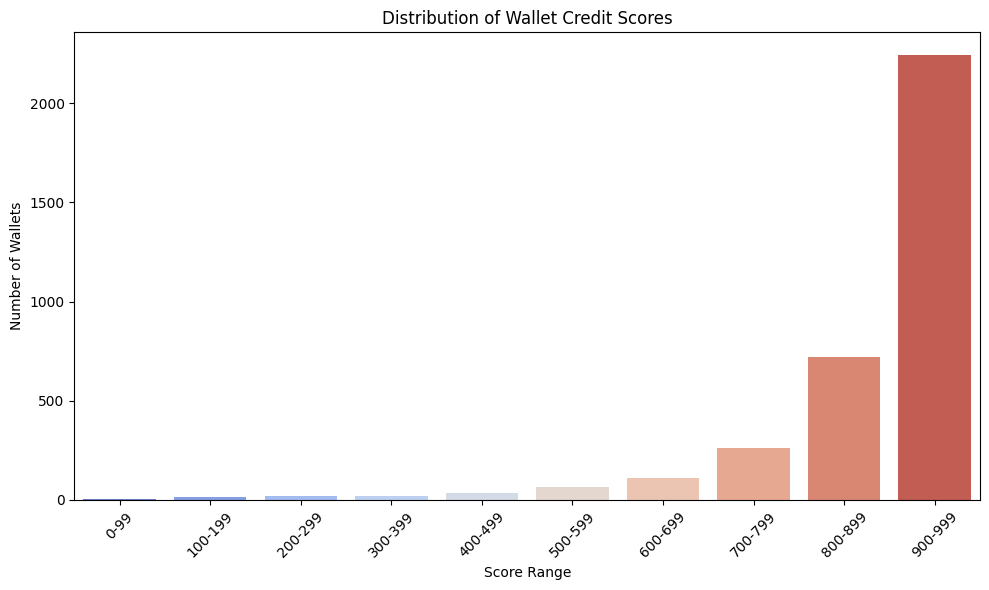

In [59]:
plt.figure(figsize=(10, 6))
sns.countplot(data=new_df, x='score_range', order=labels, palette='coolwarm')
plt.title('Distribution of Wallet Credit Scores')
plt.xlabel('Score Range')
plt.ylabel('Number of Wallets')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("wallet_score_distribution.png")
plt.show()

In [66]:
low_scoring = new_df[new_df['credit_score'] < 200]
print("\n--- Low Scoring Wallets (<200) ---")
# print("Count:", len(low_scoring))
low_scoring.head()
# print("Common actions:", low_scoring['action'].value_counts().head())
# print("Assets used:", low_scoring['assetSymbol'].value_counts().head())

,userWallet,tx_count,tx_per_day,active_days,first_tx,last_tx,duration_days,total_usd,avg_usd,deposit_usd,...,asset_diversity,growth_ratio,liquidation_count,action_ratio_deposit,action_ratio_redeemunderlying,action_ratio_borrow,action_ratio_repay,action_ratio_liquidationcall,credit_score,score_range
54,0x000f7f22bfc28d940d4b68e13213ab17cf107790,73,36.500000,3,2021-04-23 19:37:55,2021-04-26 15:28:48,2,2.088538e+08,2.861011e+06,5.756557e+07,...,5,0.433420,0,0.356164,0.205479,0.260274,0.178082,NaN,74.919487,0-99
135,0x00329e92ed6fd0a0ef76da9c476d51faeb6b26a0,523,5.077670,98,2021-04-30 04:48:46,2021-08-11 23:39:51,103,2.442716e+07,4.670586e+04,7.155138e+06,...,7,1.346623,0,0.342256,0.080306,0.294455,0.282983,NaN,144.616946,100-199
137,0x0034baeeb160a5f1032b6d124d3e87cc94d74e62,162,6.750000,12,2021-05-02 12:39:09,2021-05-27 01:29:07,24,1.912249e+08,1.180400e+06,6.056302e+07,...,2,0.012106,0,0.364198,0.228395,0.277778,0.129630,NaN,115.740382,100-199
151,0x00389de87cae34a6f89e13cc8225c4984add8b37,610,10.517241,52,2021-05-08 21:17:58,2021-07-06 03:56:47,58,1.653682e+07,2.710955e+04,6.893114e+06,...,8,4.918118,0,0.537705,0.173770,0.163934,0.124590,NaN,163.766845,100-199
311,0x0072b9af9a7dc5a42091f01d3d22bcf298d398fd,54,0.642857,14,2021-05-24 22:19:06,2021-08-17 21:33:05,84,3.487146e+07,6.457678e+05,6.802781e+06,...,1,0.090344,0,0.481481,0.166667,0.240741,0.111111,NaN,189.659090,100-199


In [135]:
high_scoring = new_df[new_df['credit_score'] > 800]
# print("\n--- High Scoring Wallets (>800) ---")
# print("Count:", len(high_scoring))
high_scoring.shape[0]
# print("Common actions:", high_scoring['action'].value_counts().head())
# print("Assets used:", high_scoring['assetSymbol'].value_counts().head())

2963

In [ ]:
# new_df['credit_score']
# ANALYSIS_FILE = "new_analysis.md"

In [75]:
df = df.merge(new_df[['userWallet','credit_score']], on='userWallet',how='left')
df.head()

,_id,userWallet,network,protocol,txHash,logId,timestamp,blockNumber,action,type,amount,assetSymbol,assetPriceUSD,poolId,userId,createdAt,updatedAt,usd_value,month,credit_score
0,681d38fed63812d4655f571a,0x00000000001accfa9cef68cf5371a23025b6d4b6,polygon,aave_v2,0x695c69acf608fbf5d38e48ca5535e118cc213a89e3d6...,0x695c69acf608fbf5d38e48ca5535e118cc213a89e3d6...,2021-08-17 05:29:26,1629178166,deposit,Deposit,2000.000000,USDC,0.993832,0x2791bca1f2de4661ed88a30c99a7a9449aa84174,0x00000000001accfa9cef68cf5371a23025b6d4b6,2025-05-08T23:06:39.465Z,2025-05-08T23:06:39.465Z,1987.663655,2021-08,964.879541
1,681aa70dd6df53021cc6f3c0,0x000000000051d07a4fb3bd10121a343d85818da6,polygon,aave_v2,0xe6fc162c86b2928b0ba9b82bda672763665152b9de9d...,0xe6fc162c86b2928b0ba9b82bda672763665152b9de9d...,2021-05-20 15:36:53,1621525013,deposit,Deposit,145.000000,WMATIC,1.970307,0x0d500b1d8e8ef31e21c99d1db9a6444d3adf1270,0x000000000051d07a4fb3bd10121a343d85818da6,2025-05-07T00:19:26.159Z,2025-05-07T00:19:26.159Z,285.694480,2021-05,992.129801
2,681d04c2d63812d4654c733e,0x000000000096026fb41fc39f9875d164bd82e2dc,polygon,aave_v2,0xe2d7eb815c89331a734ed6f204a06c385a1b39040baa...,0xe2d7eb815c89331a734ed6f204a06c385a1b39040baa...,2021-07-24 09:28:33,1627118913,deposit,Deposit,0.001000,WMATIC,0.922377,0x0d500b1d8e8ef31e21c99d1db9a6444d3adf1270,0x000000000096026fb41fc39f9875d164bd82e2dc,2025-05-08T19:23:47.877Z,2025-05-08T19:23:47.877Z,0.000922,2021-07,982.453363
3,681d133bd63812d46551b6ef,0x000000000096026fb41fc39f9875d164bd82e2dc,polygon,aave_v2,0x0d63a2eacd82b82f868db825ea7385e6bd8d046ee729...,0x0d63a2eacd82b82f868db825ea7385e6bd8d046ee729...,2021-07-31 23:15:18,1627773318,deposit,Deposit,0.004000,WMATIC,1.057483,0x0d500b1d8e8ef31e21c99d1db9a6444d3adf1270,0x000000000096026fb41fc39f9875d164bd82e2dc,2025-05-08T20:25:33.141Z,2025-05-08T20:25:33.141Z,0.004230,2021-07,982.453363
4,681899e4ba49fc91cf2f4454,0x0000000000e189dd664b9ab08a33c4839953852c,polygon,aave_v2,0x590eabb812c5006a6f4766f44e6e9d3ad0b5b563de69...,0x590eabb812c5006a6f4766f44e6e9d3ad0b5b563de69...,2021-04-19 15:25:07,1618845907,redeemunderlying,RedeemUnderlying,0.501548,USDC,1.002130,0x2791bca1f2de4661ed88a30c99a7a9449aa84174,0x7f90122bf0700f9e7e1f688fe926940e8839f353,2025-05-05T10:58:45.934Z,2025-05-05T10:58:45.934Z,0.502616,2021-04,804.000573


In [98]:
# with open(ANALYSIS_FILE, "w") as f: 
#     f.write("## Score Distribution\n")
#     f.write("![Score Distribution](wallet_score_distribution.png)\n\n")
    
#     # if 'action' in df.columns:
#         # Join credit scores from features_df into original_df based on userWallet
#         # original_df = df.merge(new_df[['userWallet', 'credit_score']], on='userWallet', how='left')

#         # Extract top 5 actions by low and high scoring wallets
#     low_actions = df[df['credit_score'] <= 200]['action'].value_counts().head(5)
#     high_actions = df[df['credit_score'] >= 800]['action'].value_counts().head(5)

#     f.write("## Common Actions (Low Scoring Wallets)\n")
#     for action, count in low_actions.items():
#         f.write(f"- {action}: {count}\n")

#     f.write("\n## Common Actions (High Scoring Wallets)\n")
#     for action, count in high_actions.items():
#         f.write(f"- {action}: {count}\n")

top_wallets = new_df[['userWallet', 'credit_score']].sort_values(by='credit_score', ascending=False).head(3)
bottom_wallets = new_df[['userWallet', 'credit_score']].sort_values(by='credit_score', ascending=True).head(3)
summary_cols = [
    'tx_count', 'tx_per_day', 'total_usd',
    'net_borrow_usd', 'net_deposit_usd',
    'asset_diversity', 'liquidation_count'
]
agg_df = new_df.groupby('score_range')[summary_cols].mean()

with open("output.md", "w") as f:
        f.write("# Credit Score Analysis\n\n")

        f.write("## Score Distribution\n")
        f.write("![Score Distribution](wallet_score_distribution.png)\n\n")

        f.write("## Summary\n")
        f.write(f"- Total wallets analyzed: {len(new_df)}\n")
        f.write(f"- Wallets with score <= 200: {low_scoring.shape[0]}\n")
        f.write(f"- Wallets with score >= 800: {high_scoring.shape[0]}\n")

        f.write("\n## Wallet Behavior by Score Range\n")
        f.write("The table below summarizes average wallet behavior across credit score ranges:\n\n")
        f.write("| Score Range | Total USD | Net Borrow USD | Net Deposit USD | Asset Diversity | Liquidations |\n")
        f.write("|-------------|-----------|----------------|-----------------|-----------------|--------------|\n")
    
        for score_range, row in agg_df.iterrows():
            f.write(f"| {score_range} | {row['total_usd']} | {row['net_borrow_usd']} | {row['net_deposit_usd']} | {row['asset_diversity']} | {row['liquidation_count']} |\n")

C:\Users\Atharva\AppData\Local\Temp\ipykernel_10464\3784238853.py:28: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg_df = new_df.groupby('score_range')[summary_cols].mean()


In [117]:
top3 = df[['userWallet','credit_score']].sort_values(by='credit_score',ascending=False)

In [111]:
num = (new_df['credit_score']==1000).sum()
print(f"full credit scored wallets with 1000, the number of these wallets is: {num}")

full credit scored wallets with 1000, the number of these wallets is: 842


In [112]:
raw_scores_new = model.decision_function(x)

array([ 0.16986858,  0.1829986 ,  0.17833619, ...,  0.0883117 ,
        0.1042162 , -0.06312696])

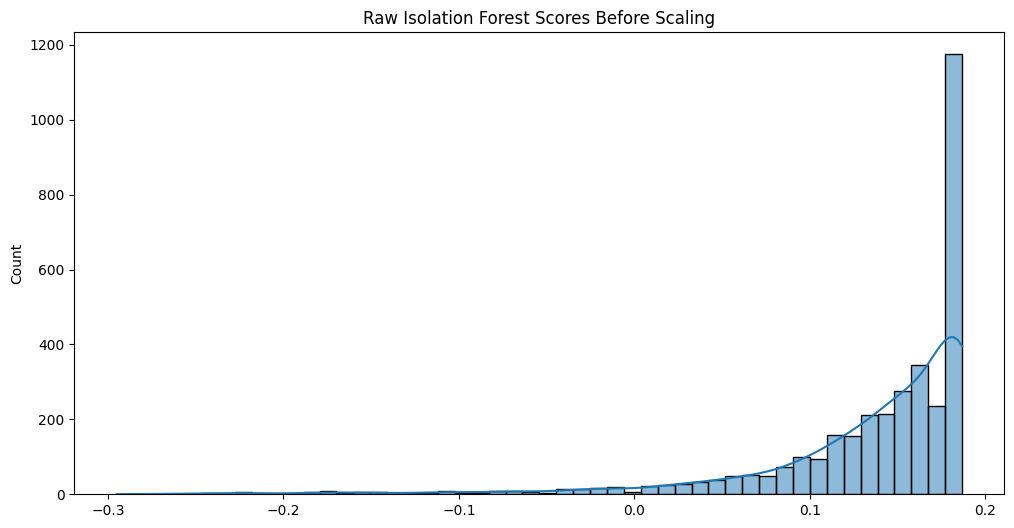

In [116]:
plt.figure(figsize=(12,6))
sns.histplot(raw_scores, bins=50, kde=True)
plt.title("Raw Isolation Forest Scores Before Scaling")
plt.show()

In [138]:
def write_analysis(df):
    with open("output.md", "w") as f:
        f.write("# Analysis of Given wallets\n")
        f.write("## Score Distribution\n")
        f.write("![Distribution](wallet_score_distribution.png)\n\n")
        f.write("## Summary\n")
        f.write(f"- Total wallets analyzed: {len(df)}\n")
        
        perfect_score_count = (df["credit_score"] == 1000).sum()
        zero_score_count = (df["credit_score"] == 0).sum()
        f.write(f"Number of wallets with perfect credit score (1000): {perfect_score_count}\n\n")
        f.write(f"Number of wallets with zero credit score (0):{zero_score_count}\n\n")

        top_wallets = df.sort_values(by="credit_score", ascending=False).head(3)
        f.write("## Top 3 Wallets by Credit Score\n")
        f.write("| Wallet | Credit Score | Net Borrow USD | Net Deposit USD | Asset Diversity | Liquidations |\n")
        f.write("|--------|--------------|----------------|-----------------|-----------------|--------------|\n")
        for _, row in top_wallets.iterrows():
            f.write(f"| {row['userWallet']} | {row['credit_score']} | {row['net_borrow_usd']:.2f} | {row['net_deposit_usd']:.2f} | {row['asset_diversity']:.2f} | {row['liquidation_count']} |\n")
        f.write("\n")

        bottom_wallets = df.sort_values(by="credit_score", ascending=True).head(3)
        f.write("## Bottom 3 Wallets by Credit Score\n")
        f.write("| Wallet | Credit Score | Total USD | Net Borrow USD | Net Deposit USD | Asset Diversity | Liquidations |\n")
        f.write("|--------|---------------|-----------|----------------|-----------------|-----------------|--------------|\n")
        for _, row in bottom_wallets.iterrows():
            f.write(f"| {row['userWallet']} | {row['credit_score']} | {row['total_usd']:.2f} | {row['net_borrow_usd']:.2f} | {row['net_deposit_usd']:.2f} | {row['asset_diversity']:.2f} | {row['liquidation_count']} |\n")
        f.write("\n")

In [139]:
write_analysis(new_df)

In [142]:
len(df['userWallet'].unique())

3497

In [ ]:
action_ratio_deposit              169
action_ratio_redeemunderlying    1837
action_ratio_borrow              1872
action_ratio_repay               2301
action_ratio_liquidationcall     3396

In [144]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [ ]:
feature = new_df.drop(['userWallet','action_ratio_deposit','action_ratio_redeemunderlying','',''])
numeric_data = feature.select_dtypes(include=['float64','int64'])
scaled_features = scaler.fit_transform(numeric_data)

In [153]:
features_to_use =["userWallet",
"tx_count",
"tx_per_day",
"active_days",
"first_tx",
"last_tx",
"duration_days",
"total_usd",
"avg_usd",
"deposit_usd",
"redeem_usd",
"borrow_usd",
"repay_usd",
"net_deposit_usd",
"net_borrow_usd",
"asset_diversity",
"growth_ratio",
"liquidation_count"
]                   

In [154]:
df1 = new_df[features_to_use].copy()

In [159]:
df1.isna().sum()

userWallet           0
tx_count             0
tx_per_day           0
active_days          0
first_tx             0
last_tx              0
duration_days        0
total_usd            0
avg_usd              0
deposit_usd          0
redeem_usd           0
borrow_usd           0
repay_usd            0
net_deposit_usd      0
net_borrow_usd       0
asset_diversity      0
growth_ratio         0
liquidation_count    0
dtype: int64

In [157]:
df1.columns

Index(['userWallet', 'tx_count', 'tx_per_day', 'active_days', 'first_tx',
       'last_tx', 'duration_days', 'total_usd', 'avg_usd', 'deposit_usd',
       'redeem_usd', 'borrow_usd', 'repay_usd', 'net_deposit_usd',
       'net_borrow_usd', 'asset_diversity', 'growth_ratio',
       'liquidation_count'],
      dtype='object')

In [194]:
def give_credit_scores(df):
    features = [
        'tx_per_day', 'duration_days', 'net_deposit_usd', 'net_borrow_usd',
        'avg_usd', 'asset_diversity', 'growth_ratio', 'liquidation_count',
        'active_days', 'deposit_usd', 'repay_usd'
    ]
    # df = df.fillna(0)
    scaler = MinMaxScaler()
    df_scaled = pd.DataFrame(scaler.fit_transform(df[features]),columns=features)

    weights = {
        'tx_per_day': 0.10,
        'duration_days': 0.10,
        'net_deposit_usd': 0.15,
        'net_borrow_usd': 0.10,
        'avg_usd': 0.10,
        'asset_diversity': 0.10,
        'growth_ratio': 0.10,
        'liquidation_count': -0.20,
        'active_days': 0.05,
        'deposit_usd': 0.05,
        'repay_usd': 0.05,       
    }

    df_scaled['raw_credit_score'] = sum(df_scaled[feature] * weight for feature, weight in weights.items())
    
    min_score = df_scaled['raw_credit_score'].min()
    max_score = df_scaled['raw_credit_score'].max()

    df_scaled['credit_score'] = ((df_scaled['raw_credit_score']-min_score)/(max_score-min_score))*1000
    df['credit_score'] = df_scaled['credit_score']
    # return df[['userWallet','credi_score']+features]

In [195]:
df2 = pd.read_csv('wallet_features.csv')

In [196]:
give_credit_scores(df2)

In [211]:
high_scoring_wallets = df2[df2['credit_score']>800]
low_scoring_wallets = df2[df2['credit_score']<200]

In [209]:
high_scoring_wallets

,userWallet,tx_count,tx_per_day,active_days,first_tx,last_tx,duration_days,total_usd,avg_usd,deposit_usd,redeem_usd,borrow_usd,repay_usd,net_deposit_usd,net_borrow_usd,asset_diversity,growth_ratio,liquidation_count,credit_score
1733,0x02eca8cc78b7d30c1ac5e16988ed2c8a9da658d6,167,1.210145,39,2021-04-14 04:41:12,2021-08-30 06:38:20,138,1.529109e+08,915633.847326,5.125899e+07,4.362004e+07,3.861795e+07,1.941386e+07,7.638951e+06,1.920409e+07,8,0.057315,0,1000.000000
3178,0x058b10cbe1872ad139b00326686ee8ccef274c58,522,12.428571,22,2021-04-30 17:34:58,2021-06-12 06:33:06,42,1.400815e+08,268355.401401,6.167728e+07,4.021341e+07,3.214389e+07,6.046944e+06,2.146387e+07,2.609695e+07,7,0.021443,0,897.151076


In [212]:
low_scoring_wallets

,userWallet,tx_count,tx_per_day,active_days,first_tx,last_tx,duration_days,total_usd,avg_usd,deposit_usd,redeem_usd,borrow_usd,repay_usd,net_deposit_usd,net_borrow_usd,asset_diversity,growth_ratio,liquidation_count,credit_score
0,0x00000000001accfa9cef68cf5371a23025b6d4b6,1,1.000000,1,2021-08-17 05:29:26,2021-08-17 05:29:26,1,1987.663655,1987.663655,1987.663655,0.0,0.0,0.0,1987.663655,0.0,1,1.000000,0,184.864813
1,0x000000000051d07a4fb3bd10121a343d85818da6,1,1.000000,1,2021-05-20 15:36:53,2021-05-20 15:36:53,1,285.694480,285.694480,285.694480,0.0,0.0,0.0,285.694480,0.0,1,1.000000,0,184.727425
2,0x000000000096026fb41fc39f9875d164bd82e2dc,2,0.285714,2,2021-07-24 09:28:33,2021-07-31 23:15:18,7,0.005152,0.002576,0.005152,0.0,0.0,0.0,0.005152,0.0,1,4.585904,0,193.274620
8,0x000000007858e6f2668e1e06111cfa24403a5466,1,1.000000,1,2021-06-06 00:47:39,2021-06-06 00:47:39,1,0.142161,0.142161,0.142161,0.0,0.0,0.0,0.142161,0.0,1,1.000000,0,184.704375
9,0x00000001a0f57e850c9db68b4a9bc34677437c5c,1,1.000000,1,2021-07-23 03:41:21,2021-07-23 03:41:21,1,1.766653,1.766653,1.766653,0.0,0.0,0.0,1.766653,0.0,1,1.000000,0,184.704506
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3479,0x0610be26ebcad7c6bd2c4fc21017583acd733b0a,1,1.000000,1,2021-06-16 20:44:12,2021-06-16 20:44:12,1,193.408232,193.408232,193.408232,0.0,0.0,0.0,193.408232,0.0,1,1.000000,0,184.719976
3489,0x061667d49211840a590513f622a92ec170de7879,1,1.000000,1,2021-06-08 04:10:06,2021-06-08 04:10:06,1,515.843250,515.843250,515.843250,0.0,0.0,0.0,515.843250,0.0,1,1.000000,0,184.746004
3490,0x061716a85aba5e37626e4a2c33596d59823d30b8,1,1.000000,1,2021-07-19 16:19:43,2021-07-19 16:19:43,1,1.178119,1.178119,1.178119,0.0,0.0,0.0,1.178119,0.0,1,1.000000,0,184.704458
3491,0x0617d8b4509d856bcfd0870b1bb27c8f68e1d536,1,1.000000,1,2021-07-19 01:47:13,2021-07-19 01:47:13,1,1.185690,1.185690,1.185690,0.0,0.0,0.0,1.185690,0.0,1,1.000000,0,184.704459


In [214]:
df2.head()

,userWallet,tx_count,tx_per_day,active_days,first_tx,last_tx,duration_days,total_usd,avg_usd,deposit_usd,redeem_usd,borrow_usd,repay_usd,net_deposit_usd,net_borrow_usd,asset_diversity,growth_ratio,liquidation_count,credit_score
0,0x00000000001accfa9cef68cf5371a23025b6d4b6,1,1.000000,1,2021-08-17 05:29:26,2021-08-17 05:29:26,1,1.987664e+03,1987.663655,1987.663655,0.000000,0.000000,0.000000,1987.663655,0.000000,1,1.000000,0,184.864813
1,0x000000000051d07a4fb3bd10121a343d85818da6,1,1.000000,1,2021-05-20 15:36:53,2021-05-20 15:36:53,1,2.856945e+02,285.694480,285.694480,0.000000,0.000000,0.000000,285.694480,0.000000,1,1.000000,0,184.727425
2,0x000000000096026fb41fc39f9875d164bd82e2dc,2,0.285714,2,2021-07-24 09:28:33,2021-07-31 23:15:18,7,5.152311e-03,0.002576,0.005152,0.000000,0.000000,0.000000,0.005152,0.000000,1,4.585904,0,193.274620
3,0x0000000000e189dd664b9ab08a33c4839953852c,17,0.131783,8,2021-04-19 15:23:17,2021-08-26 23:15:16,129,1.960723e+03,115.336644,0.000000,1960.722952,0.000000,0.000000,-1960.722952,0.000000,4,0.964258,0,457.921168
4,0x0000000002032370b971dabd36d72f3e5a7bf1ee,399,3.022727,104,2021-04-21 21:28:30,2021-09-01 18:15:24,132,1.950034e+06,4887.303993,925490.696960,824037.577815,130355.754756,70150.263791,101453.119145,60205.490965,6,0.061139,0,619.069622


In [213]:
def vis_graph(df,image_file):
    bins = list(range(0,1100,100))
    labels = [f"{b}-{b+99}" for b in bins[:-1]]
    df['score_range'] = pd.cut(df['credit_score'], bins=bins,labels=labels,include_lowest=True)
    plt.figure(figsize=(10, 6))
    sns.countplot(data=df, x='score_range', order=labels, palette='coolwarm')
    plt.title('Distribution of Wallet Credit Scores')
    plt.xlabel('Score Range')
    plt.ylabel('Number of Wallets')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(image_file)

In [215]:
image_file = "vis_graph.png"

C:\Users\Atharva\AppData\Local\Temp\ipykernel_10464\3290665485.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='score_range', order=labels, palette='coolwarm')


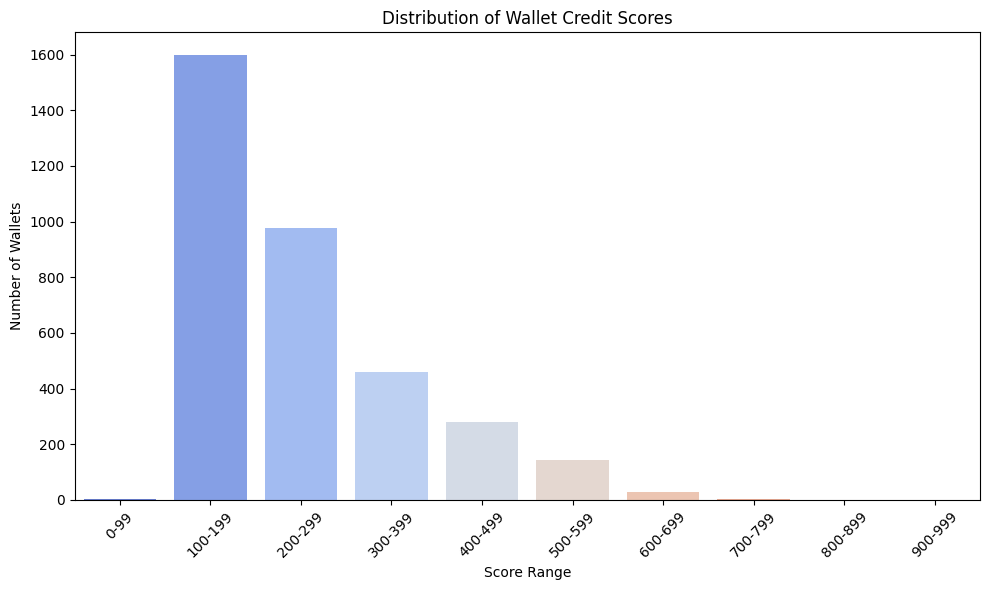

In [216]:
vis_graph(df2,image_file)

In [ ]:
def write_analysis(df):
    with open("analysis.md", "w") as f:
        f.write("# Analysis of Given wallets\n")
        f.write("## Score Distribution\n")
        f.write("![Distribution](vis_graph.png)\n\n")
        f.write("## Summary\n")
        f.write(f"- Total wallets analyzed: {len(df)}\n")
        
        perfect_score_count = (df["credit_score"] == 1000).sum()
        zero_score_count = (df["credit_score"] == 0).sum()
        f.write(f"- Number of wallets with perfect credit score (1000) : {perfect_score_count}\n\n")
        f.write(f"- Number of wallets with zero credit score (0) : {zero_score_count}\n\n")

        top_wallets = df.sort_values(by="credit_score", ascending=False).head(3)
        f.write("## Behaviour of Top 3 Wallets by Credit Score\n")
        f.write("| Wallet | Credit Score | Net Borrow USD | Net Deposit USD | Asset Diversity | Liquidations |\n")
        f.write("|--------|--------------|----------------|-----------------|-----------------|--------------|\n")
        for _, row in top_wallets.iterrows():
            f.write(f"| {row['userWallet']} | {row['credit_score']} | {row['net_borrow_usd']:.2f} | {row['net_deposit_usd']:.2f} | {row['asset_diversity']:.2f} | {row['liquidation_count']} |\n")
        f.write("\n")

        bottom_wallets = df.sort_values(by="credit_score", ascending=True).head(3)
        f.write("## Behaviour of Bottom 3 Wallets by Credit Score\n")
        f.write("| Wallet | Credit Score | Total USD | Net Borrow USD | Net Deposit USD | Asset Diversity | Liquidations |\n")
        f.write("|--------|---------------|-----------|----------------|-----------------|-----------------|--------------|\n")
        for _, row in bottom_wallets.iterrows():
            f.write(f"| {row['userWallet']} | {row['credit_score']} | {row['total_usd']:.2f} | {row['net_borrow_usd']:.2f} | {row['net_deposit_usd']:.2f} | {row['asset_diversity']:.2f} | {row['liquidation_count']} |\n")
        f.write("\n")

In [225]:
write_analysis(df2)